# Project: ReID

## Introduction

We wanted to reidentify a person, given some samples of the dataset. The idea is to learn the main features of the person in order to distinguish him/her from other people.



The first thing that we did was to import libraries.

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import SVR, LinearSVR

from load_data import DataLoader
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
import tqdm
import config
import math
import matplotlib.pyplot as plt
import scikitplot as skplt
from utils import filter_and_split_dataset



In [ ]:
d = DataLoader()
d.read_dataset()
d.shuffle_videos()
d.display_dataset()

metrics = []


The next thing to do was to design the learning setting. The first and easiest idea was to test a variety of classifiers, and see which works better for our features.

We tested different classifiers:

In [ ]:
def test_model(name, model_skel, model_clothes, model_face, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test):
    global metrics
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)


    print("-" * 10)
    print("|", name, "|")
    # Test
    print("-" * 10)
    skel_pred = model_skel.predict(X_skel_test)
    print(classification_report(y_test, skel_pred))
    print("-" * 10)
    clothes_pred = model_clothes.predict(X_clothes_test)
    print(classification_report(y_test, clothes_pred))
    print("-" * 10)
    face_pred = model_face.predict(X_face_test)
    print(classification_report(y_face_test, face_pred))

    skel_pred_roc = model_skel.predict_proba(X_skel_test)
    clothes_pred_roc = model_clothes.predict_proba(X_clothes_test)
    face_pred_roc = model_face.predict_proba(X_face_test)

    metrics.append([name.split("_")[-1].split(".")[-1], y_test, y_face_test, skel_pred, clothes_pred, face_pred, skel_pred_roc, clothes_pred_roc, face_pred_roc])


In [ ]:
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(X, y)

X_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy")
X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(X_2, y_2)



In [ ]:

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

classifiers_skel = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=3, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_clothes = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, random_state=2, splitter='best'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 10, n_estimators = 100, random_state = 4),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_face = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=9, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

fig, ((ax_roc_skel, ax_roc_clothes, ax_roc_face), (ax_det_skel, ax_det_clothes, ax_det_face)) = plt.subplots(2, 3, figsize =(20, 10))
# fig, (ax_roc_skel, ax_roc_clothes, ax_roc_face, ax_det_skel, ax_det_clothes, ax_det_face) = plt.subplots(1, 6, figsize=(50,5))

for name, model in classifiers_skel.items():
    model.fit(X_skel, y_train)
    RocCurveDisplay.from_estimator(model, X_skel_test, y_test, ax=ax_roc_skel, name=name)
    DetCurveDisplay.from_estimator(model, X_skel_test, y_test, ax=ax_det_skel, name=name)

for name, model in classifiers_clothes.items():
    model.fit(X_clothes, y_train)
    RocCurveDisplay.from_estimator(model, X_clothes_test, y_test, ax=ax_roc_clothes, name=name)
    DetCurveDisplay.from_estimator(model, X_clothes_test, y_test, ax=ax_det_clothes, name=name)

for name, model in classifiers_face.items():
    model.fit(X_face, y_face)
    RocCurveDisplay.from_estimator(model, X_face_test, y_face_test, ax=ax_roc_face, name=name)
    DetCurveDisplay.from_estimator(model, X_face_test, y_face_test, ax=ax_det_face, name=name)


ax_roc_skel.set_title("Receiver Operating Characteristic (ROC) curves - Skeleton")
ax_det_skel.set_title("Detection Error Tradeoff (DET) curves - Skeleton")
ax_roc_clothes.set_title("Receiver Operating Characteristic (ROC) curves - Clothes")
ax_det_clothes.set_title("Detection Error Tradeoff (DET) curves - Clothes")
ax_roc_face.set_title("Receiver Operating Characteristic (ROC) curves - Face")
ax_det_face.set_title("Detection Error Tradeoff (DET) curves - Face")


ax_roc_skel.grid(linestyle="--")
ax_det_skel.grid(linestyle="--")
ax_roc_clothes.grid(linestyle="--")
ax_det_clothes.grid(linestyle="--")
ax_roc_face.grid(linestyle="--")
ax_det_face.grid(linestyle="--")


plt.legend()
plt.savefig("ROC_DET_curves.png")

## Model Tuning

### Fit and Evaluate Models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


class_names = ['Different', 'Same']

def fit_models(models, X_train, y_train):
    for name, model in models.items():
        model.fit(X_train, y_train.ravel())
        print(name, 'trained.')
    return

def evaluate_models(models,model_name,X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred,zero_division=0))
        cv_accuracy = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='accuracy')
        cv_f1_macro = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='f1_macro')
        print(cross_val_score(model, X_test, y_test, scoring='accuracy'))
        print("Accuracy: %0.4f (+/- %0.4f)" % (cv_accuracy.mean(), cv_accuracy.std() * 2))
        print(cross_val_score(model, X_test, y_test, scoring='f1_macro'))
        print("f1-score: %0.4f (+/- %0.4f)" % (cv_f1_macro.mean(), cv_f1_macro.std() * 2))
        if name.count("accuracy")> 0:
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
            disp.plot(cmap=plt.cm.Blues)
            disp.ax_.set_title(name + ' (' + model_name + ')') 
        print('------------------------------------'*3)
    return  

### Model Tuning

In [ ]:

def tune_model(model, param_grid, scoring, x_train, y_train, grid_jobs):
    print('tuning...')
    clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, verbose=1, n_jobs=grid_jobs)
    clf.fit(x_train, y_train.ravel())
    print('done')
    print()
    print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
    best_params = clf.best_params_.copy()
    return best_params

### Models

In [ ]:

SVM_param_grid = {
    'C': [0.5, 1],
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'degree': [1,2,3,4,5],
    'gamma': ['scale'],
    'random_state': [2,42]
}

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}


Gauss_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

KNN_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}

DT_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}

Regres_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0.5, 1],
    'fit_intercept': [True, False],
    'intercept_scaling': [1, 2, 3],
    'class_weight': [None, 'balanced'],
    'random_state': [2,42],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'verbose': [0],
    'warm_start': [True, False],
    'n_jobs': [-1],
    'l1_ratio': [None]
}

models = {
    "KNN": (KNeighborsClassifier, KNN_param_grid),
    "DT": (DecisionTreeClassifier, DT_param_grid),
    "RF": (RandomForestClassifier, RF_param_grid),
    "GNB": (GaussianNB, Gauss_param_grid),
    "SVM": (SVC, SVM_param_grid),
    # "LogReg": (LogisticRegression(), Regres_param_grid),
}

### Tuning and Evaluation

In [ ]:

for model in models:
    print(model)
    current_model = models[model]
    best_accuracy_params_skel = tune_model(current_model[0](), current_model[1], 'accuracy', X_skel, y_train, -1)
    best_f1macro_params_skel = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_skel, y_train, -1)
    best_accuracy_params_clothes = tune_model(current_model[0](), current_model[1], 'accuracy', X_clothes, y_train, -1)
    best_f1macro_params_clothes = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_clothes, y_train, -1)
    best_accuracy_params_face = tune_model(current_model[0](), current_model[1], 'accuracy', X_face, y_face, -1)
    best_f1macro_params_face = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_face, y_face, -1)
    tuned_models_skel = {
        'Skeleton accuracy': current_model[0](**best_accuracy_params_skel),
        'Skeleton f1_macro': current_model[0](**best_f1macro_params_skel)
    }

    tuned_models_clothes = {
        'Clothes accuracy': current_model[0](**best_accuracy_params_clothes),
        'Clothes f1_macro': current_model[0](**best_f1macro_params_clothes)
    }

    tuned_models_face = {
        'Face accuracy': current_model[0](**best_accuracy_params_face),
        'Face f1_macro': current_model[0](**best_f1macro_params_face)
    }
        
    fit_models(tuned_models_skel, X_skel, y_train)
    fit_models(tuned_models_clothes, X_clothes, y_train)
    fit_models(tuned_models_face, X_face, y_face)
    print("-"*50)
    print("Skeleton")
    evaluate_models(tuned_models_skel,model, X_skel, y_train)
    print("-"*50)
    print("Clothes")
    print("-"*50)
    evaluate_models(tuned_models_clothes,model, X_clothes, y_train)
    print("-"*50)
    print("Face")
    print("-"*50)
    evaluate_models(tuned_models_face,model, X_face, y_face)


### Results
| Model | Skeleton | Clothes | Face | 
| :--- | :---: | :---: | :---: | 
| DT | 0.91 | 0.93  | 0.81 |
| RF | 0.93 | 0.94  | 0.85 |
| SVC | 0.91 | 0.93  | 0.81 |
| GNB | 0.89 | 0.79  | 0.81 |
| KNN | 0.94 | 0.94  | 0.84 |

In [ ]:
# Train the models on the big dataset

X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)

model_skel = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=3, p=1, weights='distance')#  RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42)
model_clothes = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance')# RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, random_state = 42)
model_face = SVC(C = 1, kernel = "poly", degree = 3, gamma = "auto", probability = True, random_state = 2)


model_skel.fit(X_skel, y_train)
model_clothes.fit(X_clothes, y_train)
model_face.fit(X_face, y_face)

# Sample dataset live

X, y, images = d.sample_dataset(video=0, return_images=True, seed=10)
X_train, _, y_train, __, images_train, ___ = train_test_split(X, y, images, stratify=y)
print(y_train)

print("-" * 10)
print("skel")
skel_pred = model_skel.predict(X_train[:, : 9])
print(classification_report(y_train, skel_pred))
print("-" * 10)
print("clothes")
clothes_pred = model_clothes.predict(X_train[:, 9 : 9 + config.NUM_POINTS_LBP])
print(classification_report(y_train, clothes_pred))
print("-" * 10)


# print("face")
# X_face = []
# y_face = []

# for i in range(len(X_train)):
#     if not math.isnan(X_train[i][0]):
#         X_face.append(X_train[i])
#         y_face.append(y_train[i])
        
# face_pred = model_face.predict(X_face)
# print(classification_report(y_face, face_pred))



target = np.where(y_train == 1)
target_img = images_train[target[0][0]]

fig, ax = plt.subplots(len(images_train) // 5, 5)
fig.set_size_inches(18.5, 10.5)

for i in range(len(y_train)):
    t, el = y_train[i], images_train[i]
    ax[i // 5, i % 5].imshow(el)
plt.show()
 

for idx in range(len(y_train)):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax[0].imshow(images_train[idx])
    ax[0].set_title(f"True label: {y_train[idx]}, predict: {bool(skel_pred[idx] or clothes_pred[idx])}")
    ax[1].imshow(target_img)
    ax[1].set_title("Target")#"skel label: " + str(bool(res[1][0])), "clothes label: " + str(bool(res[1][1])), "face label: " + str(bool(res[1][2])))
    print(skel_pred[idx], clothes_pred[idx])
    plt.show()

## Regression

We also thought that it was possible to learn a "latent space" that ensambles that person's features. The idea is that a regressor can learn how to optimize the outpot of a linear combination so that features from the person that we want to re-identify will output a low value (0) while the other people will output an higher value (1).

Given that, we tested some regressors in order to learn the features of a person.

In [ ]:
# X_logistic, y_logistc, _ = d.sample_dataset(video=0, return_images=False)
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
y -= 1
y *= -1
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)

X = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy")
y -= 1
y *= -1
X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic = filter_and_split_dataset(X, y)
c_svr = 0

def test_regression(name, model_skel, model_clothes, model_face, 
        X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test,
        X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic):
    
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)

    # Train the logistic regressor
    log_reg_skel, log_reg_clothes, log_reg_face = LogisticRegression(max_iter = 10000), LogisticRegression(max_iter = 10000), LogisticRegression(max_iter = 10000)

    log_reg_skel.fit(model_skel.predict(X_skel_logistic).reshape(-1, 1), y_train_logistic)
    log_reg_clothes.fit(model_clothes.predict(X_clothes_logistic).reshape(-1, 1), y_train_logistic)
    log_reg_face.fit(model_face.predict(X_face_logistic).reshape(-1, 1), y_face_logistic)

    # Test
    print("-" * 10)
    print("|", name, "|")
    print("-" * 10)
    print("| skel |")
    skel_pred = model_skel.predict(X_skel_test)

    log_skel_pred = log_reg_skel.predict(skel_pred.reshape(-1, 1))

    print(classification_report(y_test, log_skel_pred, zero_division=0))
    print(mean_absolute_error(y_test, skel_pred))
    print(mean_squared_error(y_test, skel_pred))

    print("| clothes |")
    clotehs_pred = model_clothes.predict(X_clothes_test)
    
    log_clotehs_pred = log_reg_clothes.predict(clotehs_pred.reshape(-1, 1))

    print(classification_report(y_test, log_clotehs_pred, zero_division=0))
    print(mean_absolute_error(y_test, clotehs_pred))
    print(mean_squared_error(y_test, clotehs_pred))

    print("| face |")
    face_pred = model_face.predict(X_face_test)
    log_face_pred = log_reg_face.predict(face_pred.reshape(-1, 1))

    print(classification_report(y_face_test, log_face_pred, zero_division=0))
    print(mean_absolute_error(y_face_test, face_pred))
    print(mean_squared_error(y_face_test, face_pred))

    plt.plot(y_test, clotehs_pred, 'o')
    plt.show()

    plt.plot(y_test, skel_pred, 'o')
    plt.show()

    plt.plot(y_face_test, face_pred, 'o')
    plt.show()

----------
| Pipeline |
----------
| skel |
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.98       375

    accuracy                           0.97       388
   macro avg       0.48      0.50      0.49       388
weighted avg       0.93      0.97      0.95       388

0.7757731958938789
0.7757731958762887
| clothes |
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.98       375

    accuracy                           0.97       388
   macro avg       0.48      0.50      0.49       388
weighted avg       0.93      0.97      0.95       388

0.14144803568259956
0.08080409620363274
| face |
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.97      1.00      0.99       117

    accuracy                           

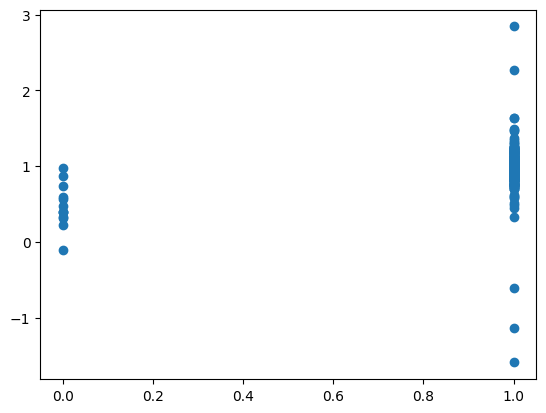

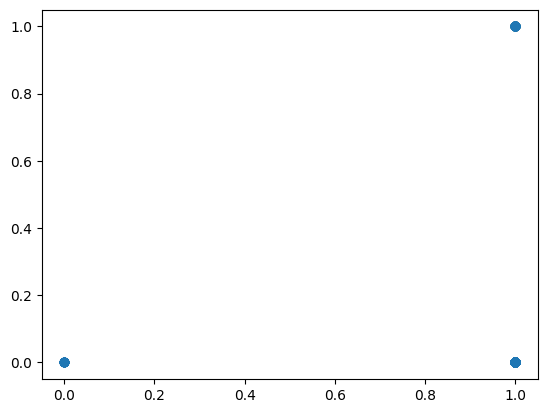

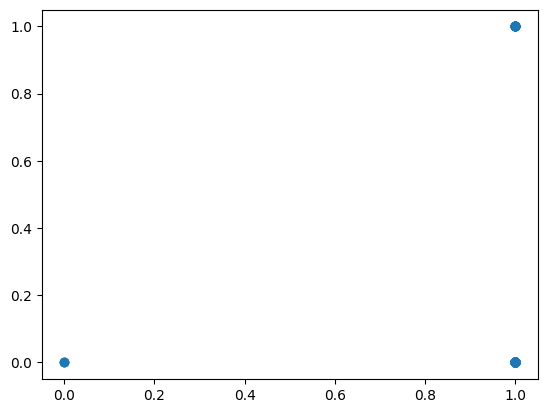

In [55]:
m1 = Pipeline([("poly", PolynomialFeatures(degree=4)),("LinReg", SVC())])
m2 = Pipeline([("poly", PolynomialFeatures(degree=4)),("LinReg", SVC())])
m3 = Pipeline([("poly", PolynomialFeatures(degree=4)),("LinReg", SVC())])

test_regression("Pipeline", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test, X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic)

----------
| Pipeline |
----------
| skel |
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.98       375

    accuracy                           0.97       388
   macro avg       0.48      0.50      0.49       388
weighted avg       0.93      0.97      0.95       388

0.03350515463917526
0.03350515463917526
| clothes |
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.97      1.00      0.98       375

    accuracy                           0.97       388
   macro avg       0.48      0.50      0.49       388
weighted avg       0.93      0.97      0.95       388

0.03350515463917526
0.03350515463917526
| face |
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.97      1.00      0.99       117

    accuracy                         

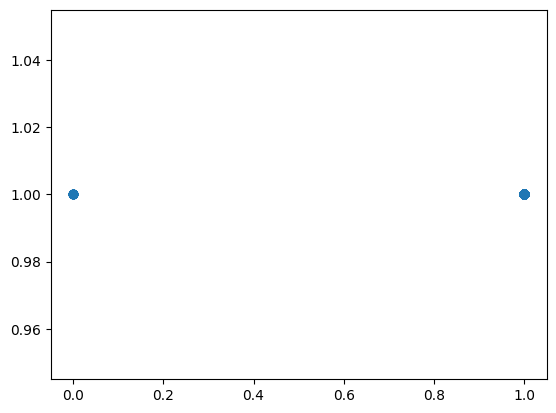

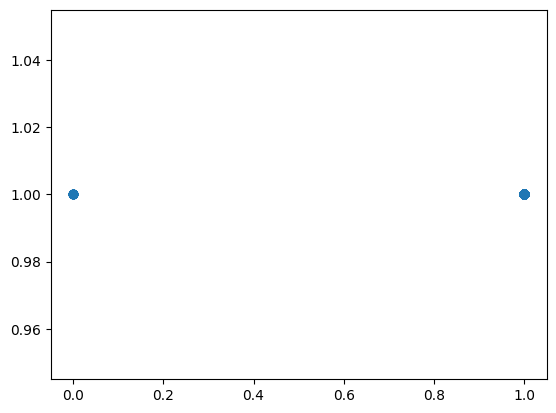

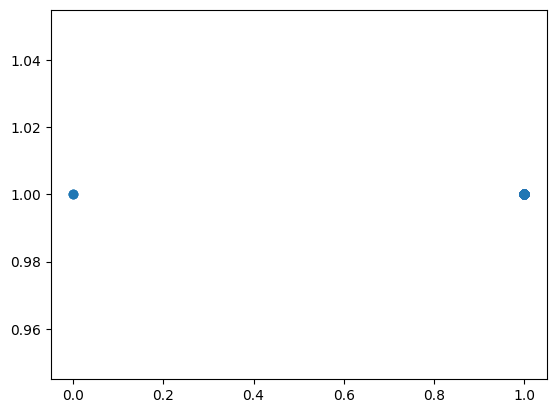

In [56]:
m1 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("Regression", SVC())])
m2 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("Regression", SVC())])
m3 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("Regression", SVC())])
test_regression("Pipeline", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test, X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic)

Epoch 1/100
37/37 [==============================] - 0s 3ms/step - loss: 2.2059 - accuracy: 0.0336 - mse: 35.4137 - val_loss: 0.6931 - val_accuracy: 0.0335 - val_mse: 0.9665
Epoch 2/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.0336 - mse: 0.9674 - val_loss: 0.6931 - val_accuracy: 0.0335 - val_mse: 0.9665
Epoch 3/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.0336 - mse: 0.9673 - val_loss: 0.6931 - val_accuracy: 0.0335 - val_mse: 0.9665
Epoch 4/100
37/37 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.0336 - mse: 0.9673 - val_loss: 0.6931 - val_accuracy: 0.0335 - val_mse: 0.9665
Epoch 5/100
37/37 [==============================] - 0s 947us/step - loss: 0.6925 - accuracy: 0.0336 - mse: 0.9673 - val_loss: 0.6931 - val_accuracy: 0.0335 - val_mse: 0.9665
Epoch 6/100
37/37 [==============================] - 0s 939us/step - loss: 0.6924 - accuracy: 0.0336 - mse: 0.9673 - val_loss: 0.693

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


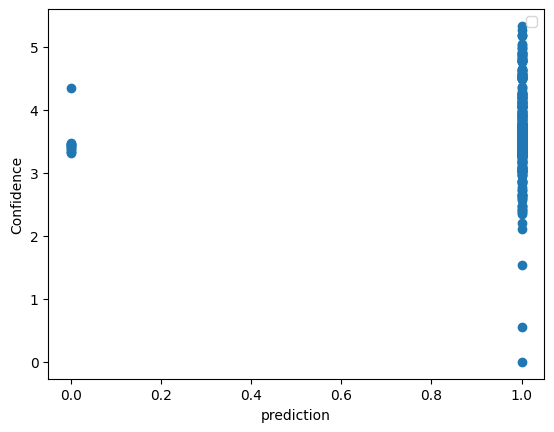

In [63]:
import tensorflow as tf

from tensorflow import keras
from keras import models, layers, Sequential, metrics

model = models.Sequential()
model.add(layers.Dense(units=9, input_shape=(9,)))
model.add(layers.ReLU())
model.add(layers.Dense(units=9))
model.add(layers.ReLU())
model.add(layers.Dense(units=2))
model.add(layers.ReLU())
model.add(layers.Flatten())

# model.summary()

opt = keras.optimizers.SGD()
opt.learning_rate.assign(0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', 'mse'])

history = model.fit(X_skel, y_train, epochs=100, 
                    validation_data=(X_skel_test, y_test))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('prediction')
plt.ylabel('Confidence')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

test_acc = model.evaluate(X_skel_test,  y_test)
print(test_acc)

print("| face |")
face_pred = model.predict(X_skel_test)

res = []
for i in face_pred:
    if i[0] > i[1]:
        res.append(i[0])
    else:
        res.append(i[1])


plt.plot(y_test, res, 'o')
plt.legend()
plt.show()



The first thing that we did was to read the dataset and extract the information that we need in order to recognize people:

Best paramatri